In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
df = pd.read_csv('combined_data.csv')
df

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...
...,...,...
83443,0,hi given a date how do i get the last date of ...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...
83446,0,subscribe change profile contact us long term ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

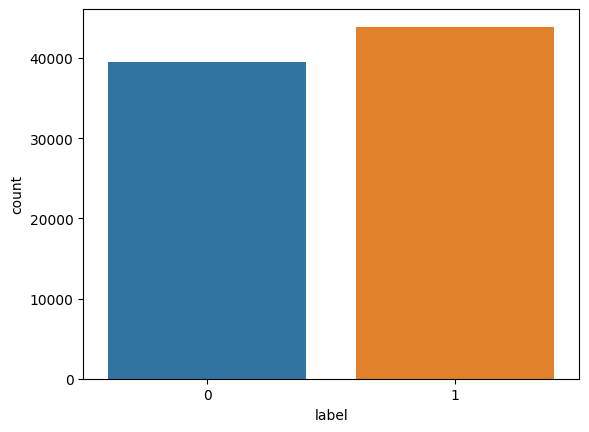

In [ ]:
sns.countplot(x = 'label', data = df)
plt.show()

In [ ]:
labels = {0 : "Not Spam", 1 : "Spam"}
label_counts = df['label'].value_counts()
print(label_counts)

1    43910
0    39538
Name: label, dtype: int64


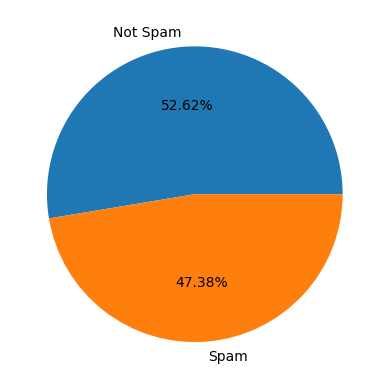

In [ ]:
plt.pie(label_counts, labels = labels.values(), autopct = "%.2f%%")
plt.show()

In [ ]:
df.groupby(df['label']).describe()


text                                                               
       count unique                                                top freq
label                                                                      
0      39538  39538   computer connection from cnn com wednesday es...    1
1      43910  43910  ounce feather bowl hummingbird opec moment ala...    1

In [ ]:
df.isna().sum()


label    0
text     0
dtype: int64

In [ ]:
print(f"Number of duplicated urls : {np.sum(df.duplicated())}")

df.drop_duplicates(inplace = True)

print(f"Number of duplicated urls (after dropping duplicates) : {np.sum(df.duplicated())}")

Number of duplicated urls : 0
Number of duplicated urls (after dropping duplicates) : 0


In [ ]:
df.shape

(83448, 2)

In [ ]:
train_texts = df['text'].tolist()
train_labels = df['label'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts,train_labels,test_labels = train_test_split(train_texts,train_labels,test_size =.2,random_state=55,shuffle = True)
train_texts, val_texts,train_labels,val_labels = train_test_split(train_texts,train_labels,test_size =.2,random_state=55,shuffle = True)

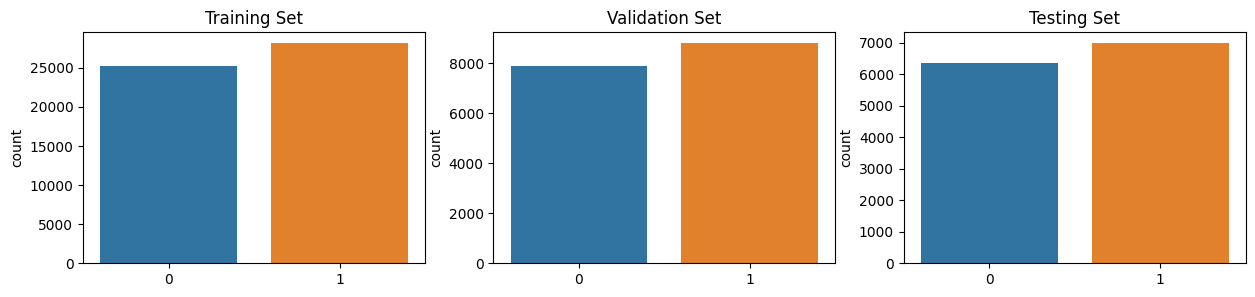

In [ ]:
# Checking whether the labels are distributed uniformely

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title("Training Set")
sns.countplot(x=train_labels)

plt.subplot(1, 3, 2)
plt.title("Validation Set")
sns.countplot(x=test_labels)

plt.subplot(1, 3, 3)
plt.title("Testing Set")
sns.countplot(x=val_labels)

plt.show()

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

(…).co/roberta-base/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…).co/roberta-base/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(…)co/roberta-base/resolve/main/config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
import torch

class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
      self.encodings = encodings
      self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SpamDataset(train_encodings, train_labels)
test_dataset = SpamDataset(test_encodings, test_labels)
val_dataset = SpamDataset(val_encodings,val_labels)


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 8.4 MB/s eta 0:00:00


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from transformers import RobertaForSequenceClassification
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset,batch_size = 8,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size = 8,shuffle=True)

optim = torch.optim.AdamW(model.parameters(), lr=1e-6)

training_losses = []
validation_losses = []
testing_losses = []
testing_predictions = []
testing_labels = []

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
for epoch in range(2):
  #Training
  model.train()
  for step,batch in enumerate(train_loader):
      optim.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs[0]
      loss.backward()
      optim.step()

      training_losses.append(loss.item())

      if step % 150 == 0:
        print(f'Training - Epoch: {epoch}, Step: {step}, Loss: {loss.item()}')


  # Validation
  model.eval()
  with torch.no_grad():
    val_loss = 0.0
    val_steps = 0
    for val_batch in val_loader:
      input_ids = val_batch['input_ids'].to(device)
      attention_mask = val_batch['attention_mask'].to(device)
      labels = val_batch['labels'].to(device)
      val_outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
      val_loss += val_outputs[0].item()
      val_steps += 1
      average_val_loss = val_loss / val_steps
      validation_losses.append(average_val_loss)

      if val_steps % 50 == 0:
        print(f'Validation - Epoch: {epoch}, Average Loss: {average_val_loss}')



Training - Epoch: 0, Step: 0, Loss: 0.6902682781219482
Training - Epoch: 0, Step: 150, Loss: 0.5739467740058899
Training - Epoch: 0, Step: 300, Loss: 0.05710402876138687
Training - Epoch: 0, Step: 450, Loss: 0.23420484364032745
Training - Epoch: 0, Step: 600, Loss: 0.3078751564025879
Training - Epoch: 0, Step: 750, Loss: 0.017369819805026054
Training - Epoch: 0, Step: 900, Loss: 0.024333709850907326
Training - Epoch: 0, Step: 1050, Loss: 0.12576915323734283
Training - Epoch: 0, Step: 1200, Loss: 0.05878739804029465
Training - Epoch: 0, Step: 1350, Loss: 0.009626633487641811
Training - Epoch: 0, Step: 1500, Loss: 0.012124499306082726
Training - Epoch: 0, Step: 1650, Loss: 0.0338362418115139
Training - Epoch: 0, Step: 1800, Loss: 0.023706119507551193
Training - Epoch: 0, Step: 1950, Loss: 0.30597156286239624
Training - Epoch: 0, Step: 2100, Loss: 0.020762626081705093
Training - Epoch: 0, Step: 2250, Loss: 0.01361367292702198
Training - Epoch: 0, Step: 2400, Loss: 0.34961771965026855
Trai

In [59]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    test_steps = 0

    for test_batch in test_loader:
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)

        test_outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += test_outputs[0].item()
        test_steps += 1

        average_test_loss = test_loss / test_steps
        testing_losses.append(average_test_loss)

        if test_steps % 100 == 0:
          print(f'Test - Average Loss: {average_test_loss}')

        # Collecting predictions and labels for further analysis
        testing_predictions.extend(torch.argmax(test_outputs.logits, dim=1).cpu().numpy())
        testing_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(testing_labels, testing_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test - Average Loss: 0.04376759472128469
Test - Average Loss: 0.0501718767118291
Test - Average Loss: 0.04265867135429289
Test - Average Loss: 0.04523291570629226
Test - Average Loss: 0.045960975459427574
Test - Average Loss: 0.04614835658847975
Test - Average Loss: 0.0445022976058369
Test - Average Loss: 0.043804891302788744
Test - Average Loss: 0.0430420397730389
Test - Average Loss: 0.041960887917724905
Test - Average Loss: 0.04299795483836946
Test - Average Loss: 0.042308316819059354
Test - Average Loss: 0.042710516412760344
Test - Average Loss: 0.0425645422244062
Test - Average Loss: 0.04137123079714365
Test - Average Loss: 0.04100645419268403
Test - Average Loss: 0.041006361456204427
Test - Average Loss: 0.04104573220538441
Test - Average Loss: 0.040813405658853684
Test - Average Loss: 0.0404204792965611
Test Accuracy: 0.9865188735769922


In [42]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(testing_labels, testing_predictions, average='binary')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'Support: {support}')

Precision: 0.9898250828855608
Recall: 0.9845349101660222
F1-score: 0.9871729091841971
Support: None


In [26]:
print("Quartiles for the training loss values : ")
print(np.quantile(training_losses, [0,0.25,0.5,0.75,1]))

print("Quartiles for the validation loss values : ")
print(np.quantile(validation_losses, [0,0.25,0.5,0.75,1]))

print("Quartiles for the testing loss values : ")
print(np.quantile(testing_losses, [0,0.25,0.5,0.75,1]))

Quartiles for the training loss values : 
[0.00115915 0.00784755 0.02153286 0.08219913 0.7264567 ]
Quartiles for the validation loss values : 
[0.00277197 0.0356257  0.04370469 0.04629998 0.10504349]
Quartiles for the testing loss values : 
[0.00187293 0.0412299  0.04172633 0.04241284 0.04829631]


In [27]:
text = "Hello freind, you were just awarded for a free vacation on turkey"
ids = tokenizer.encode(text,add_special_tokens = True, return_tensors = "pt").to(device)

with torch.no_grad():
  output = model(ids)

logits = output.logits
predicted_class = torch.argmax(logits,dim=1).item()

print(f"Predicted class : {predicted_class}")

Predicted class : 1


In [28]:
model.save_pretrained('spam-detection-model')

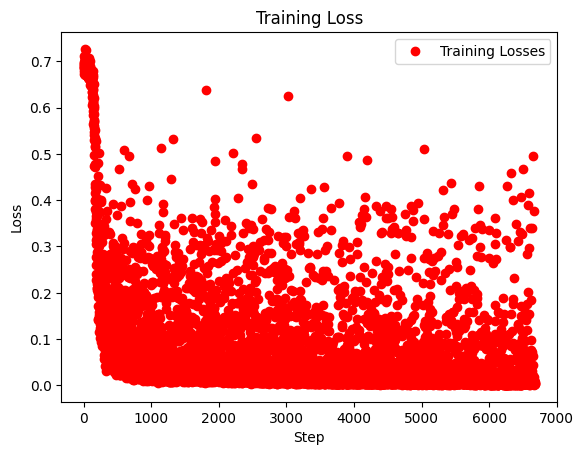

In [29]:
train_steps = range(1, len(training_losses) + 1)

plt.plot(train_steps, training_losses, 'ro', label='Training Losses')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

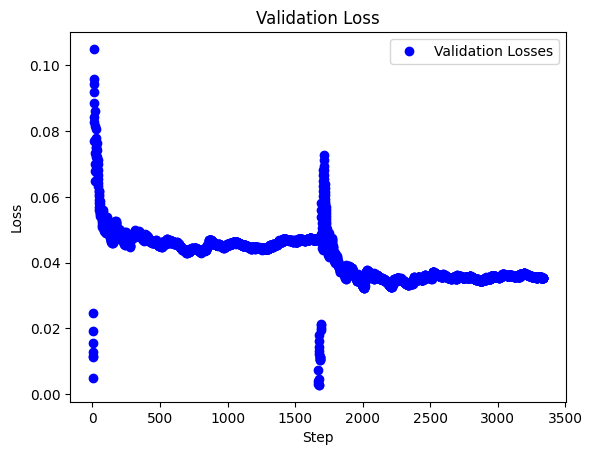

In [30]:
val_steps = range(1, len(validation_losses) + 1)

plt.plot(val_steps, validation_losses, 'bo', label='Validation Losses')
plt.title('Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.show()

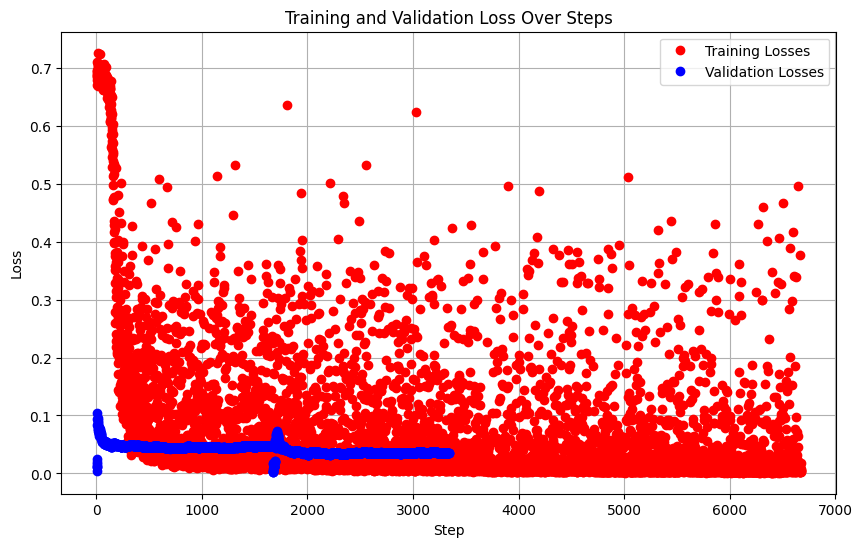

In [31]:
train_steps = range(1, len(training_losses) + 1)
val_steps = range(1,len(validation_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, training_losses, 'ro', label='Training Losses')
plt.plot(val_steps, validation_losses, 'bo', label='Validation Losses')
plt.title('Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

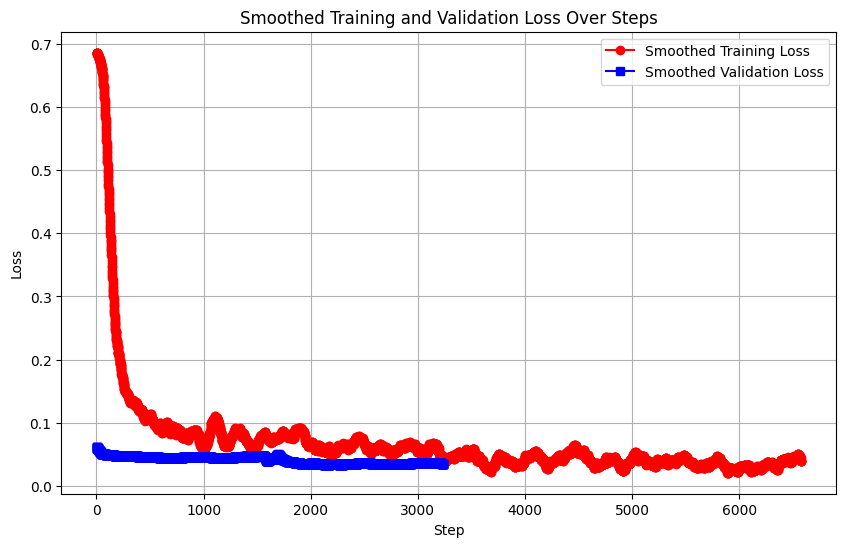

In [47]:
smoothed_training_losses = np.convolve(training_losses, np.ones(100) / 100, mode='valid')
smoothed_validation_losses = np.convolve(validation_losses, np.ones(100) / 100, mode='valid')

train_steps = range(1,len(smoothed_training_losses) + 1)
val_steps = range(1,len(smoothed_validation_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, smoothed_training_losses, label='Smoothed Training Loss', marker='o',color='red')
plt.plot(val_steps, smoothed_validation_losses, label='Smoothed Validation Loss', marker='s',color='blue')
plt.title('Smoothed Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

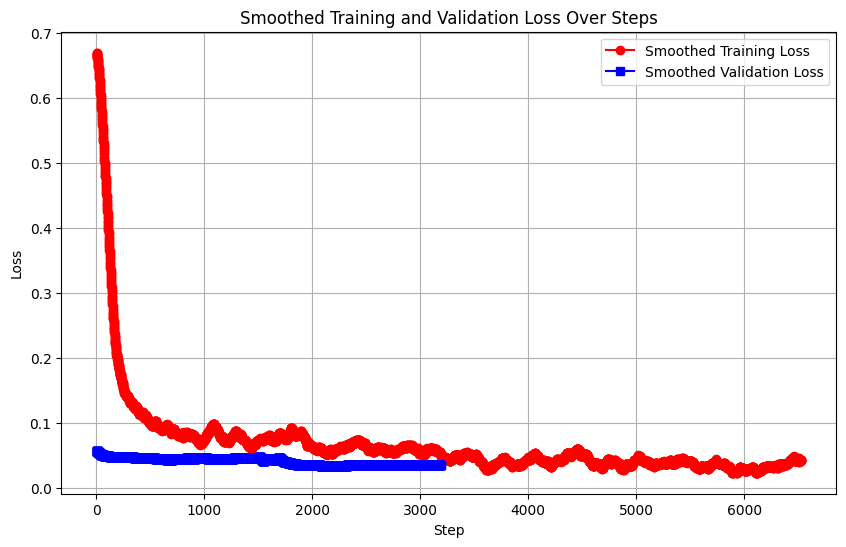

In [49]:
smoothed_training_losses = np.convolve(training_losses, np.ones(150) / 150, mode='valid')
smoothed_validation_losses = np.convolve(validation_losses, np.ones(150) / 150, mode='valid')

train_steps = range(1,len(smoothed_training_losses) + 1)
val_steps = range(1,len(smoothed_validation_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, smoothed_training_losses, label='Smoothed Training Loss', marker='o',color='red')
plt.plot(val_steps, smoothed_validation_losses, label='Smoothed Validation Loss', marker='s',color='blue')
plt.title('Smoothed Training and Validation Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

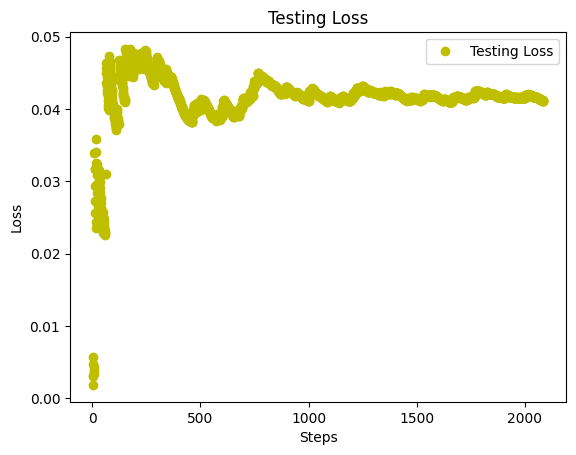

In [33]:
test_steps = range(1, len(testing_losses) + 1)

plt.plot(test_steps, testing_losses, 'yo', label='Testing Loss')
plt.title('Testing Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

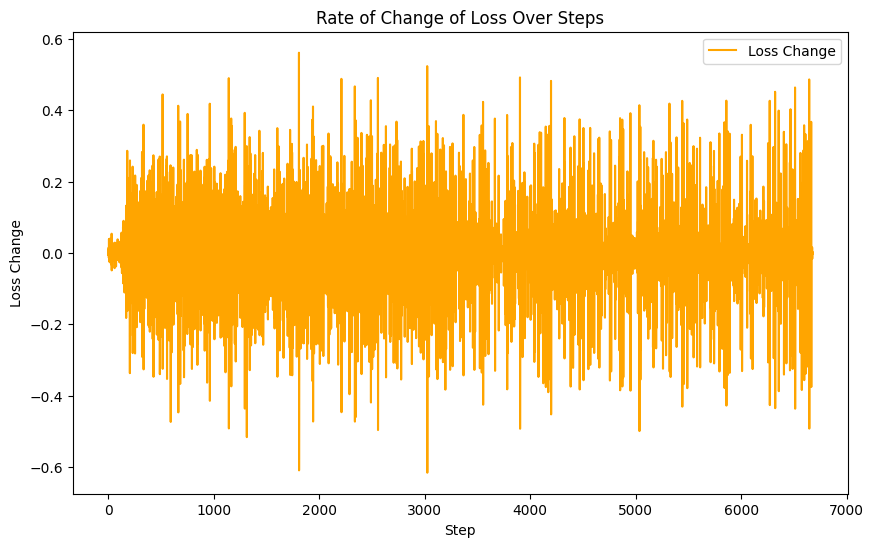

In [34]:
loss_change = [loss - training_losses[i - 1] if i > 0 else 0 for i, loss in enumerate(training_losses)]
train_steps = range(1,len(training_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, loss_change, label='Loss Change', color='orange')
plt.title('Rate of Change of Loss Over Steps')
plt.xlabel('Step')
plt.ylabel('Loss Change')
plt.legend()
plt.show()

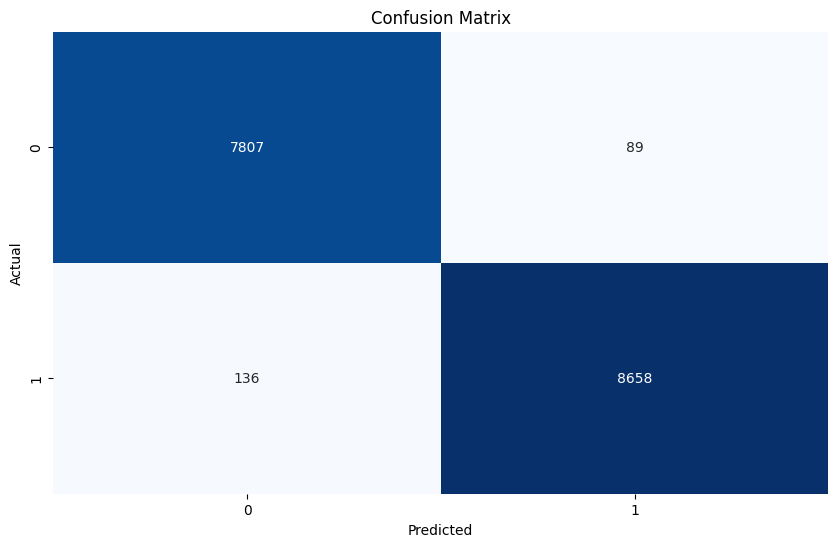

In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_labels, testing_predictions)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

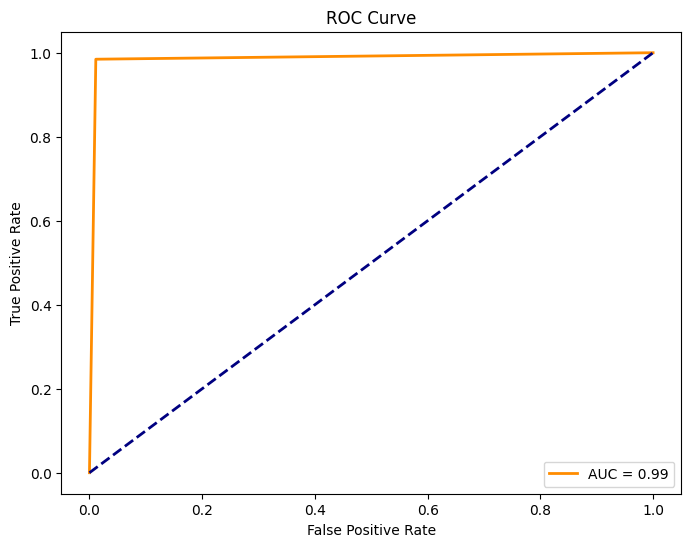

In [37]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(testing_labels, testing_predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
!pip install jiwer
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.6 MB/s eta 0:00:00


In [53]:
import math
from jiwer import wer
from nltk.translate.bleu_score import corpus_bleu

testing_labels_str = [str(label) for label in testing_labels]
testing_predictions_str = [str(prediction) for prediction in testing_predictions]


wer_score = wer(testing_labels_str, testing_predictions_str)
print(f'Test Word Error Rate: {wer_score}')

bleu_score = corpus_bleu([[ref] for ref in testing_labels_str], [hyp for hyp in testing_predictions_str])
print(f'Test Bleu Score: {bleu_score}')

bleu_score_nonlog = math.exp(bleu_score)

print(f'Test Bleu Score (non-log scale): {bleu_score_nonlog}')

Test Word Error Rate: 0.17963630723895932
Test Bleu Score: 1.7338436466239634e-231
Test Bleu Score (non-log scale): 1.0


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

#This Place is for testing the model performance before training

In [43]:
model_naive = RobertaForSequenceClassification.from_pretrained('roberta-base')
model_naive.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [45]:
model_naive.eval()
with torch.no_grad():
    test_loss = 0.0
    test_steps = 0

    for test_batch in test_loader:
        input_ids = test_batch['input_ids'].to(device)
        attention_mask = test_batch['attention_mask'].to(device)
        labels = test_batch['labels'].to(device)

        test_outputs = model_naive(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += test_outputs[0].item()
        test_steps += 1

        average_test_loss = test_loss / test_steps
        testing_losses.append(average_test_loss)

        if test_steps % 50 == 0:
          print(f'Test - Average Loss: {average_test_loss}')

        # Collecting predictions and labels for further analysis
        testing_predictions.extend(torch.argmax(test_outputs.logits, dim=1).cpu().numpy())
        testing_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(testing_labels, testing_predictions)
print(f'Test Accuracy: {test_accuracy}')

Test - Average Loss: 0.7139279389381409
Test - Average Loss: 0.7063024145364761
Test - Average Loss: 0.707440108458201
Test - Average Loss: 0.7079023352265358
Test - Average Loss: 0.7090086784362793
Test - Average Loss: 0.7084232391913732
Test - Average Loss: 0.7087304253237589
Test - Average Loss: 0.7082164578139782
Test - Average Loss: 0.7076586041185591
Test - Average Loss: 0.7081095558404923
Test - Average Loss: 0.7082538061792201
Test - Average Loss: 0.7081707879900933
Test - Average Loss: 0.7080639011126298
Test - Average Loss: 0.7081212690898351
Test - Average Loss: 0.7083388922214509
Test - Average Loss: 0.7081805622577667
Test - Average Loss: 0.7079933423855725
Test - Average Loss: 0.7084617775016361
Test - Average Loss: 0.7076816796001635
Test - Average Loss: 0.7081371043920517
Test - Average Loss: 0.7082105902263096
Test - Average Loss: 0.7081867692687295
Test - Average Loss: 0.7079918422387994
Test - Average Loss: 0.7081224525968234
Test - Average Loss: 0.7079232733249664
T